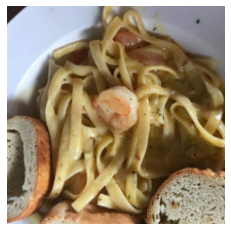

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from build_vocab import Vocabulary
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time
from data_loader import get_loader
import json
import sys

data_dir = '../data'
checkpoints_dir='../test1/inversecooking/model/checkpoints'


# code will run in gpu if available and if the flag is set to True, else it will run on cpu

use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

# code below was used to save vocab files so that they can be loaded without Vocabulary class

#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))


vars_to_replace = ['greedy', 'recipe_only', 'ingrs_only', 'temperature', 'batch_size', 'maxseqlen',
                       'get_perplexity', 'use_true_ingrs', 'eval_split', 'save_dir', 'aux_data_dir',
                       'recipe1m_dir', 'project_name', 'use_lmdb', 'beam']
store_dict = {}
#for var in vars_to_replace:

#    store_dict[var] = getattr(args, var)

args = pickle.load(open(os.path.join(checkpoints_dir, 'args.pkl'), 'rb'))
#for var in vars_to_replace:

#    setattr(args, var, store_dict[var])

#print (args)

where_to_save = os.path.join(args.save_dir, args.project_name, args.model_name)
checkpoints_dir = os.path.join(where_to_save, 'checkpoints')
logs_dir = os.path.join(where_to_save, 'logs')

notebook = True

if not notebook:
    sys.stdout = open(os.path.join(logs_dir, 'sample.log'), 'w')
    sys.stderr = open(os.path.join(logs_dir, 'sample.err'), 'w')

transforms_list = []
transforms_list.append(transforms.Resize((args.crop_size)))
transforms_list.append(transforms.CenterCrop(args.crop_size))
transforms_list.append(transforms.ToTensor())
transforms_list.append(transforms.Normalize((0.485, 0.456, 0.406),
                                                (0.229, 0.224, 0.225)))

# Image preprocessing

transform = transforms.Compose(transforms_list)

# data loader

data_dir = args.recipe1m_dir
data_loader, dataset = get_loader(data_dir, args.aux_data_dir, args.eval_split,
                                args.maxseqlen, args.maxnuminstrs, args.maxnumlabels,
                                args.maxnumims, transform, args.batch_size,
                                shuffle=False, num_workers=args.num_workers,
                                drop_last=False, max_num_samples=-1,
                                use_lmdb=args.use_lmdb, suff=args.suff)
ingrs_vocab = dataset.get_ingrs_vocab()
vocab = dataset.get_instrs_vocab().idx2word

ingr_vocab_size = dataset.get_ingrs_vocab_size()
instrs_vocab_size = dataset.get_instrs_vocab_size()

args.numgens = 1

# Build the model

output_dim = instrs_vocab_size

print (instrs_vocab_size, ingr_vocab_size)

t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
print(args.save_dir)
#model_path = os.path.join(args.save_dir, args.project_name, args.model_name, 'checkpoints', 'modelbest.ckpt')
model_path ='/scratch/ntallapr/inversecooking/test1/inversecooking/model/checkpoints/modelbest.ckpt'

# Load the trained model parameters

model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

for img_file in demo_files:
    

    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])
    
            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))
    
            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))
    
            print ('='*20)
    
        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])

